# EzyRB Tutorial 3

## Tutorial for developing ROM using Neural-Network shift Proper Orthogonal Decomposition : NNsPOD-ROM

In this tutorial we will explain how to use the **NNsPOD-ROM** algorithm implemented in **EZyRB** library.

NNsPOD algorithm is purely a data-driven machine learning method that seeks for an optimal mapping of the various snapshots to a reference configuration via an automatic detection [1] and seeking for the low-rank linear approximation subspace of the solution manifold. The nonlinear transformation of the manifold leads to an accelerated KnW decay, resulting in a low-dimensional linear approximation subspace, and enabling the construction of efficient and accurate reduced order models. The complete workflow of the NNsPOD-ROM algorithm, comprising of both the offline and online phases is presented in [2]. 

References: 

[1] Papapicco, D., Demo, N., Girfoglio, M., Stabile, G., & Rozza, G.(2022). The Neural Network shifted-proper orthogonal decomposition: A machine learning approach for non-linear reduction of hyperbolic equations.Computer Methods in Applied Mechanics and Engineering, 392, 114687 - https://doi.org/10.1016/j.cma.2022.114687

[2] Gowrachari, H., Demo, N., Stabile, G., & Rozza, G. (2024). Non-intrusive model reduction of advection-dominated hyperbolic problems using neural network shift augmented manifold transformations. arXiv preprint - https://arxiv.org/abs/2407.18419.

### Problem defintion 

We consider **1D gaussian distribution functions**, in wihch $x$ is random variable, $ \mu $ is mean and $ \sigma^2 $ is variance, where $ \sigma $ is the standard deviation or the width of gaussian.
$$
f(x)=\frac{1}{\sigma \sqrt{2 \pi}} e^{-(x-\mu)^2 /\left(2 \sigma^2\right)}
$$

To mimic travelling waves, here we parameterize the mean $\mu$ values, where changing $\mu$ shifts the distribution along x-axis, 

### Initial setting

First of all import the required packages: We need the standard Numpy, Torch, Matplotlib, and some classes from EZyRB.

* `numpy:` to handle arrays and matrices we will be working with.
* `torch:` to enable the usage of Neural Networks
* `matplotlib:` to handle the plotting environment. 

From `EZyRB` we need:
1. The `ROM` class, which performs the model order reduction process.
2. A module such as `Database`, where the matrices of snapshots and parameters are stored. 
3. A dimensionality reduction method such as Proper Orthogonal Decomposition `POD`
4. An interpolation method to obtain an approximation for the parametric solution for a new set of parameters such as the Radial Basis Function `RBF`, or Multidimensional Linear Interpolator `Linear`.

In [1]:
import numpy as np
import torch
from scipy import spatial
from matplotlib import pyplot as plt

from ezyrb import POD, RBF, Database, Snapshot, Parameter, Linear, ANN
from ezyrb import ReducedOrderModel as ROM
from ezyrb.plugin import AutomaticShiftSnapshots

In [2]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def wave(t, res=256):
    x = np.linspace(0, 11, res)
    return x, gaussian(x, t, 0.2).T   # parameterizing mean value

## Offline phase 

In this case, we obtain 15 snapshots from the analytical model. 

In [3]:
n_params = 20
params = np.linspace(0.75, 10.25, n_params).reshape(-1, 1)

pod = POD(rank=1)  
rbf = RBF()
db = Database()

for param in params:
    space, values = wave(param)
    snap = Snapshot(values=values.T, space=space)
    db.add(Parameter(param), snap)
    
print("Snapshot shape : ", db.snapshots_matrix.shape)
print("Parameter shape : ", db.parameters_matrix.shape)

Snapshot shape :  (20, 256)
Parameter shape :  (20, 1)


In [4]:
db_train, db_test = db.split([0.7,0.3])
print("Lenght of training data set:", len(db_train))
print(f"Parameters of training set: \n {db_train.parameters_matrix.flatten()}")

print("Lenght of test data set:", len(db_test))
print(f"Parameters of testing set: \n {db_test.parameters_matrix.flatten()}")

Lenght of training data set: 10
Parameters of training set: 
 [ 0.75  1.25  1.75  2.25  4.25  5.75  6.75  7.25  8.25 10.25]
Lenght of test data set: 10
Parameters of testing set: 
 [2.75 3.25 3.75 4.75 5.25 6.25 7.75 8.75 9.25 9.75]


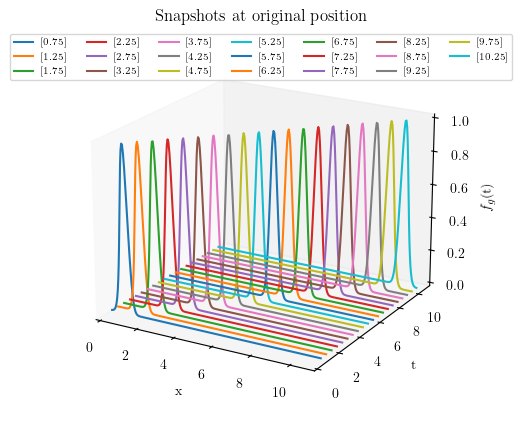

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

fig1 = plt.figure(figsize=(5,5))
ax = fig1.add_subplot(111,projection='3d')

for param in params:
    space, values = wave(param)
    snap = Snapshot(values=values.T, space=space)
    ax.plot(space, param*np.ones(space.shape), values, label = f"{param}")
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$f_{g}$(t)')
ax.set_xlim(0,11)
ax.set_ylim(0,11)
ax.set_zlim(0,1)
ax.legend(loc="upper center", ncol=7, prop = { "size": 7})
ax.grid(False)
ax.view_init(elev=20, azim=-60, roll=0)
ax.set_title("Snapshots at original position")
plt.show()

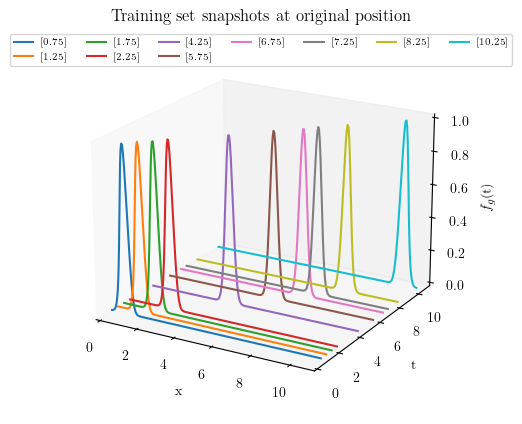

In [6]:
#%% 3D PLOT : db_train snpashots at original position
fig2 = plt.figure(figsize=(5,5))
ax = fig2.add_subplot(111, projection='3d')

for i in range(len(db_train)):
    ax.plot(space,(db_train.parameters_matrix[i]*np.ones(space.shape)), db_train.snapshots_matrix[i], label = db_train.parameters_matrix[i])
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$f_{g}$(t)')
ax.set_xlim(0,11)
ax.set_ylim(0,11)
ax.set_zlim(0,1)
ax.legend(loc="upper center", ncol=7, prop = { "size": 7})
ax.grid(False)
ax.view_init(elev=20, azim=-60, roll=0)
ax.set_title("Training set snapshots at original position")
plt.show()

`InterpNet:` must learn the reference configuration in the best possible way w.r.t its grid point distribution such that it will be able to reconstruct field values for every shifted centroid disrtribution.  

`ShiftNet:` will learn the shift operator for a given problem, which quantifies the optimal-shift, resulting in shifted space that transports all the snapshots to the reference frame.  

`Training:` The training of ShiftNet and InterpNet are seperated with the latter being trained first. Once the network has learned the best-possible reconstruct of the solution field of the reference configuration, its forward map will be used for the training of Shiftnet as well, in a cascaded fashion. For this reason, we  must optimise the loss of interpnet considerably  more than ShiftNet's. 

In [7]:
torch.manual_seed(1)

interp = ANN([10,10], torch.nn.Softplus(), [1e-6, 200000], frequency_print=1000, lr=0.03)
shift  = ANN([], torch.nn.LeakyReLU(), [1e-4, 10000], optimizer=torch.optim.Adam, frequency_print=500, l2_regularization=0,  lr=0.0023)

rom = ROM(
    database=db_train, 
    reduction=pod, 
    approximation=rbf, 
    plugins=[
        AutomaticShiftSnapshots(
                shift_network= shift,
                interp_network=interp,
                interpolator=Linear(fill_value=0), 
                reference_index=4, 
                parameter_index=4,
                barycenter_loss=20.)
            ]
        )
rom.fit()

[epoch      1]	9.481097e-02
[epoch   1000]	8.699183e-04
[epoch   2000]	2.833343e-04
[epoch   3000]	2.237887e-04
[epoch   4000]	8.693286e-05
[epoch   5000]	1.746940e-04
[epoch   6000]	3.705018e-04
[epoch   7000]	2.127307e-04
[epoch   8000]	2.243504e-04
[epoch   9000]	2.415243e-04
[epoch  10000]	1.948413e-04
[epoch  11000]	1.753031e-04
[epoch  12000]	1.503890e-04
[epoch  13000]	4.594039e-05
[epoch  14000]	3.103350e-05
[epoch  15000]	3.298146e-05
[epoch  16000]	1.537998e-04
[epoch  17000]	9.464601e-05
[epoch  18000]	3.442888e-05
[epoch  19000]	2.077208e-05
[epoch  20000]	5.421949e-06
[epoch  21000]	1.213722e-04
[epoch  22000]	3.847213e-03
[epoch  23000]	1.937839e-05
[epoch  24000]	2.462789e-06
[epoch  25000]	1.905237e-06
[epoch  26000]	1.776191e-06
[epoch  27000]	1.913055e-06
[epoch  28000]	4.166663e-06
[epoch  28905]	9.984991e-07
[epoch      1]	1.316348e+01
[epoch    500]	2.764158e+00
[epoch   1000]	1.835817e+00
[epoch   1500]	1.201066e+00
[epoch   2000]	7.641235e-01
[epoch   2500]	3.536

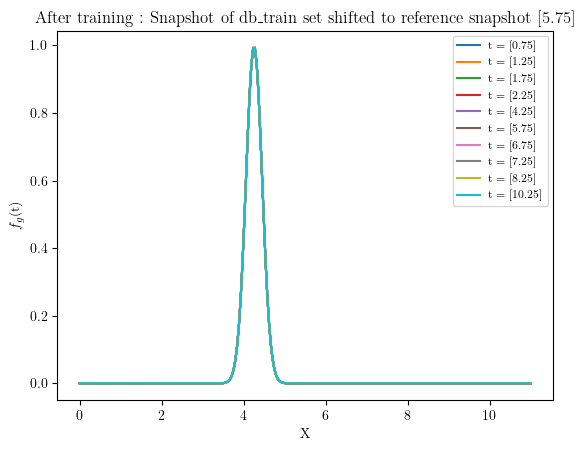

In [8]:
#%% Snapshots shifted reference position after training
for i in range(len(db_train.parameters_matrix)):
    plt.plot(space, rom.shifted_database.snapshots_matrix[i], label = f"t = {db_train.parameters_matrix[i]}") #rom._shifted_reference_database.parameters_matrix
    plt.legend(prop={'size': 8})
    plt.ylabel('$f_{g}$(t)') 
    plt.xlabel('X')
    plt.title(f'After training : Snapshot of db_train set shifted to reference snapshot {db_train.parameters_matrix[5]}')
plt.show()

Showing the snapshots before (left) and after pre-processing (right) of solution manifold

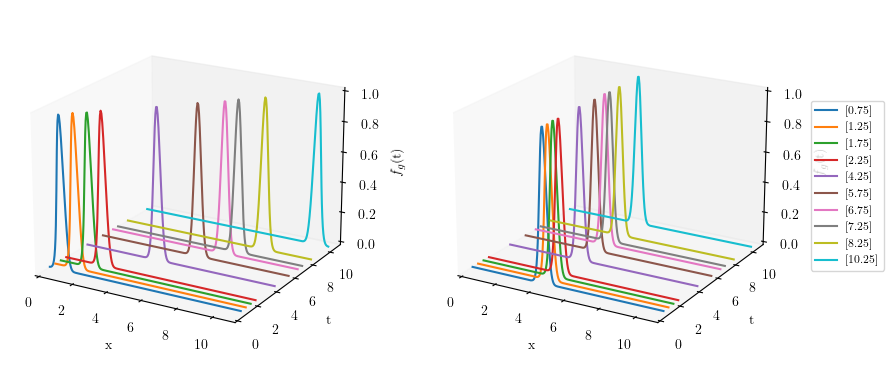

In [9]:
fig3 = plt.figure(figsize=(10, 5))

# First subplot
ax1 = fig3.add_subplot(121, projection='3d')
for i in range(len(db_train)):
    ax1.plot(space, (db_train.parameters_matrix[i] * np.ones(space.shape)), db_train.snapshots_matrix[i])
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('$f_{g}$(t)')
ax1.set_xlim(0,11)
ax1.set_ylim(0,11)
ax1.set_zlim(0,1)
ax1.grid(False)
ax1.view_init(elev=20, azim=-60, roll=0)

# Second subplot
ax2 = fig3.add_subplot(122, projection='3d')
for i in range(len(rom.shifted_database)):
    ax2.plot(space, (rom.shifted_database.parameters_matrix[i] * np.ones(space.shape)), 
             rom.shifted_database.snapshots_matrix[i], label=rom.shifted_database.parameters_matrix[i])
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('$f_{g}$(t)')
ax2.set_xlim(0, 11)
ax2.set_ylim(0, 11)
ax2.set_zlim(0, 1)
ax2.grid(False)
ax2.view_init(elev=20, azim=-60, roll=0)
handles, labels = ax2.get_legend_handles_labels()
fig3.legend(handles, labels, loc='center right', ncol=1, prop={'size': 8})
plt.show()

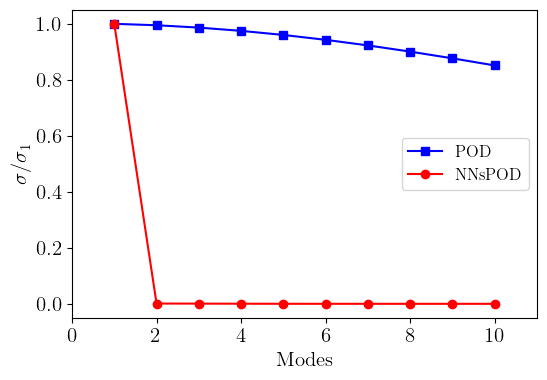

In [10]:
#%% Singular values of original snapshots and shifted snapshots
U, s = np.linalg.svd(db.snapshots_matrix.T, full_matrices=False)[:2]
N_modes = np.linspace(1, len(s),len(s))

# Singular values of shifted snapshots 
U_shifted , s_shifted = np.linalg.svd(rom.shifted_database.snapshots_matrix.T, full_matrices=False)[:2]
N_modes_shifted = np.linspace(1, len(s_shifted),len(s_shifted))

# Compare singular values
plt.figure(figsize=(6,4))
plt.plot(N_modes[:10], s[:10]/np.max(s),"-s",color = "blue", label='POD')
plt.plot(N_modes_shifted, s_shifted/np.max(s_shifted),"-o", color = "red", label='NNsPOD')
plt.ylabel('$\sigma/\sigma_{1}$', size=15) 
plt.xlabel('Modes', size=15)
plt.xlim(0, 11)
plt.legend(fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

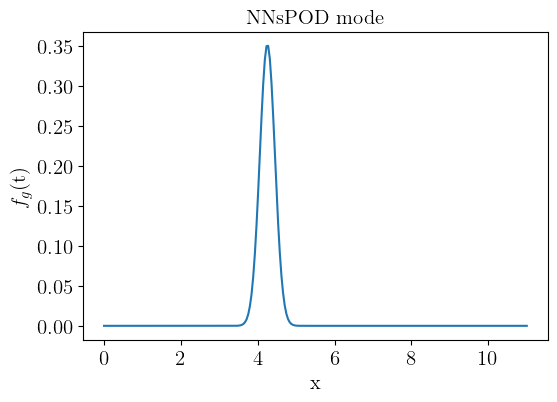

In [11]:
#%% POD MODES 
modes = pod.modes
plt.figure(figsize=(6,4))
plt.plot(space, modes*-1)
plt.ylabel('$f_{g}$(t)', size=15) 
plt.xlabel('x', size=15)
plt.title('NNsPOD mode', size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Online phase 

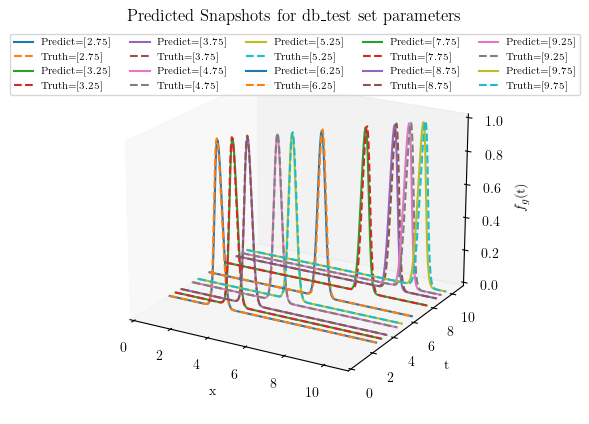

In [12]:
#%% Test set predictions using NNsPOD
pred = rom.predict(db_test.parameters_matrix) # Calculate predicted solution for given mu

fig5 = plt.figure(figsize=(5,5))
ax = fig5.add_subplot(111, projection='3d')
for i in range(len(pred)):
    space, orig = wave(db_test.parameters_matrix[i])
    ax.plot(space,(db_test.parameters_matrix[i]*np.ones(space.shape)), pred[i].values.flatten(), label = f'Predict={db_test.parameters_matrix[i]}')
    ax.plot(space,(db_test.parameters_matrix[i]*np.ones(space.shape)), orig, '--', label = f'Truth={db_test.parameters_matrix[i]}')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$f_{g}$(t)')
ax.set_xlim(0,11)
ax.set_ylim(0,11)
ax.set_zlim(0,1)
ax.legend(loc="upper center", ncol=5, prop = { "size": 7})
ax.grid(False)
ax.view_init(elev=20, azim=-60, roll=0)
ax.set_title('Predicted Snapshots for db_test set parameters')
plt.show()

In [13]:
#%% Compute Error
def error(test, norm = np.linalg.norm):
    predicted_test = rom.predict(test.parameters_matrix)
    try:
        tmp = np.array([m.values.flatten() for m in predicted_test])
    except AttributeError:
        tmp = predicted_test

    return  norm(tmp - test.snapshots_matrix,
        axis=1) / norm(test.snapshots_matrix, axis=1)

#%% Reconstruction and prediction error
train_err = error(db_train)
test_err = error(db_test)

print('Mean Train error: ', np.mean(train_err))
print('Mean Test error: ', np.mean(test_err))

Mean Train error:  0.18376772345814538
Mean Test error:  0.16368744263939966
